In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu

Start import
Working on midway2-0417.rcc.local with the following versions 
and installation paths:
strax
	v0.13.9	/dali/lgrandi/strax/strax/strax
straxen
	v0.15.5	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [42]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_commissioning_kr*',
                       available=('event_info','peak_basics'))
#dsets = dsets[(dsets.end < pd.to_datetime('01/28/2021'))]
dsets = dsets[(dsets.end > pd.to_datetime('01/23/2021'))]
print('total number of runs:', len(dsets))

total number of runs: 172


In [ ]:
dsets

# Kr-83m data

Loading event_info_double: |          | 0.00 % [00:00<?]

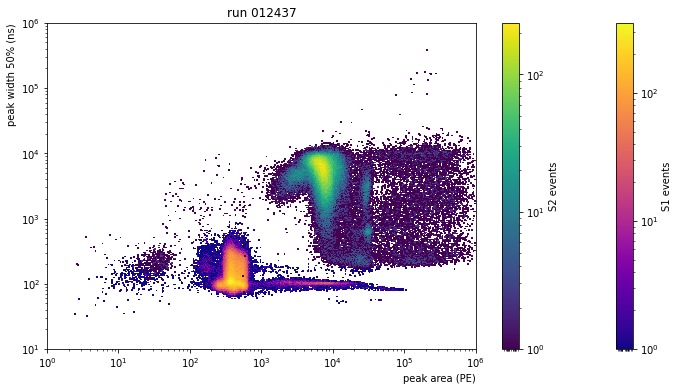

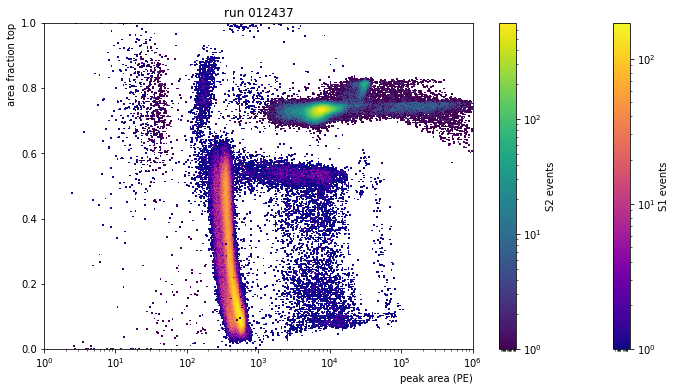

In [3]:
run_kr = '012437'  #2021-01-28 14:00 new data with a liquid level of ~5.5 mm
events = st.get_df(run_kr,'event_info_double')
ddu.plot_area_width_aft(events,run_kr)

# Cut KrSingleS1 (from Maxime)

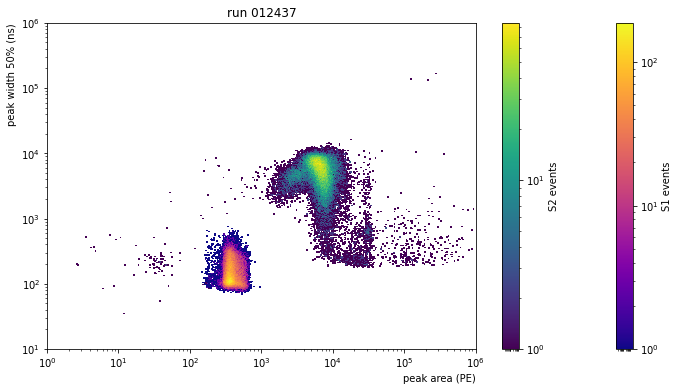

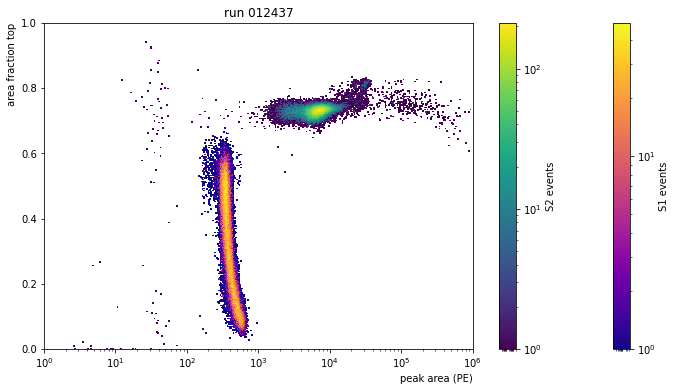

In [4]:
mask_singleS1 = ddu.mask_KrSingleS1(events)
ddu.plot_area_width_aft(events[mask_singleS1], run_kr)

# Cut KrDouble (from Maxime)

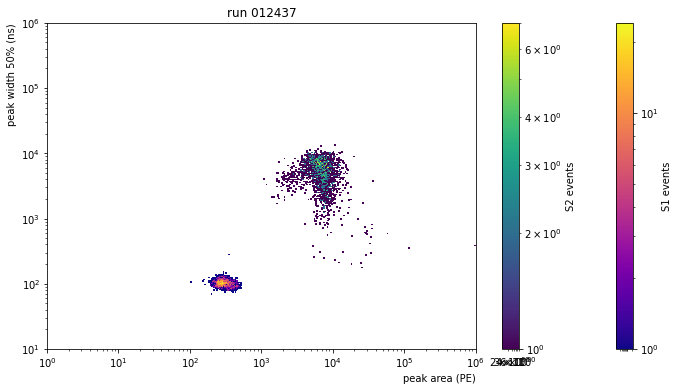

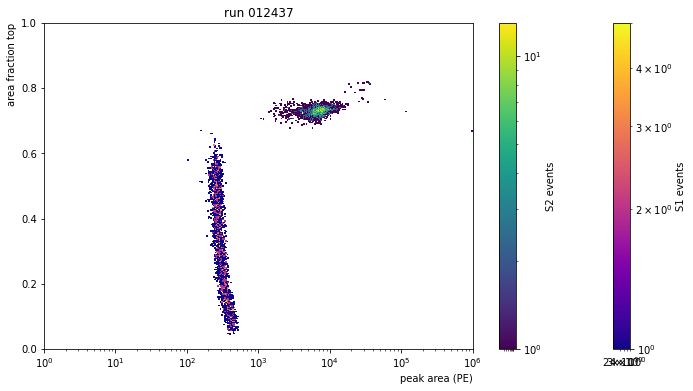

In [5]:
mask_doubleS1 = ddu.mask_KrDouble(events)
ddu.plot_area_width_aft(events[mask_doubleS1], run_kr)

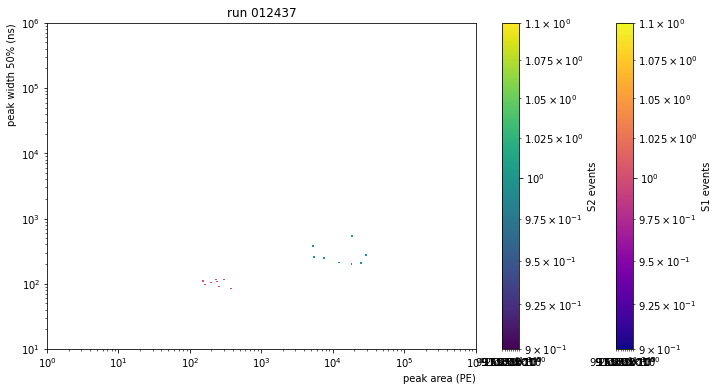

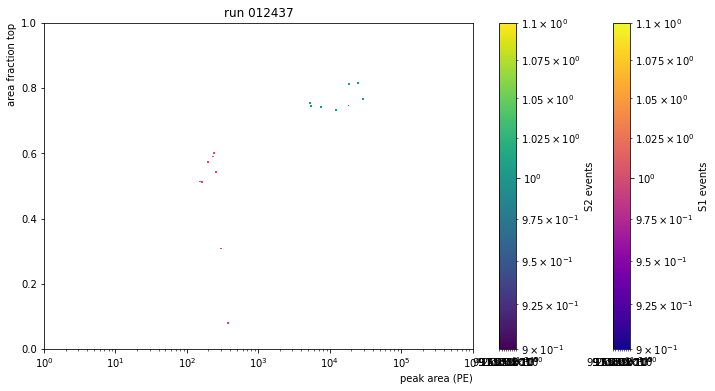

In [6]:
mask_doubleS1S2 = ddu.mask_KrDouble(events,True)
ddu.plot_area_width_aft(events[mask_doubleS1S2], run_kr)

# Cut on S2 Area, Width and Area Fraction Top

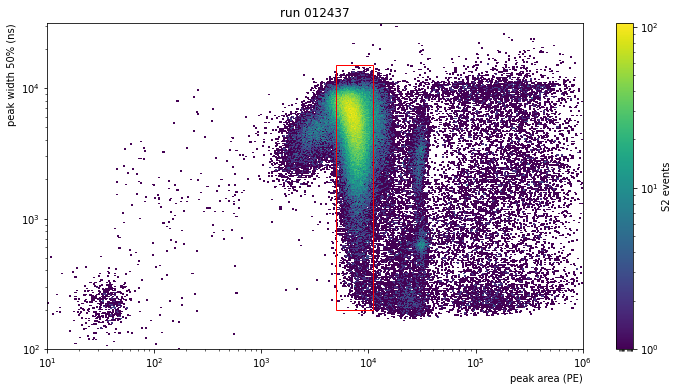

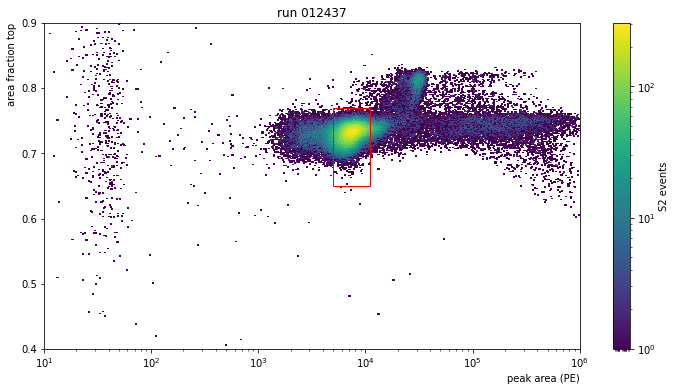

In [7]:
mask_awt = ddu.mask_s2_area_width_aft(events,run_kr,area_cut=(5e3,1.1e4),width_cut=(200,1.5e4),aft_cut=(0.65,0.77),plot=True)

In [8]:
def s2_width_vs_dt(dt,s2width, run_id):
    t = np.linspace(0, 3000, 200)
    ph = Histdd(dt, s2width,bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)

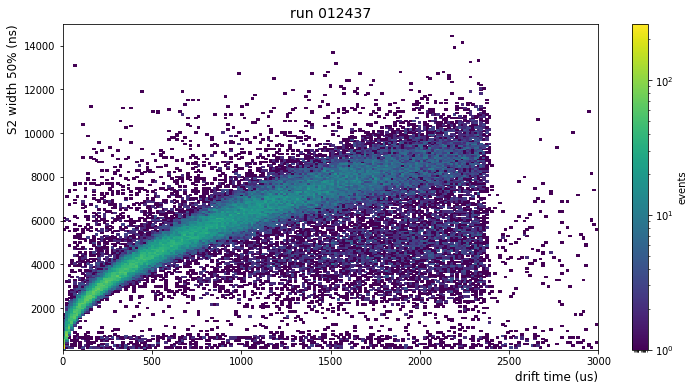

In [9]:
e1 = events[mask_singleS1]
s2_width_vs_dt(e1['drift_time']/1e3,e1['s2_a_range_50p_area'],run_kr)

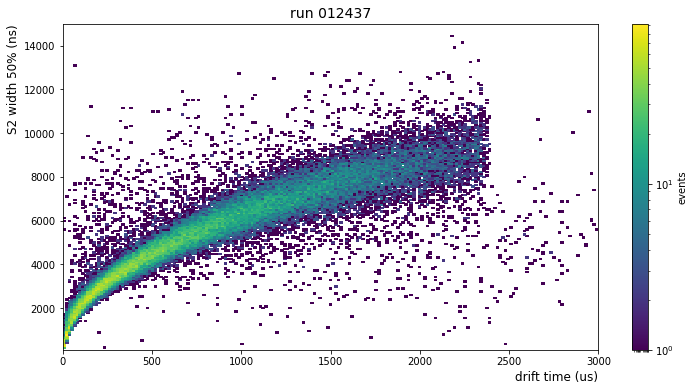

In [10]:
e2 = events[mask_singleS1 & mask_awt]
s2_width_vs_dt(e2['drift_time']/1e3,e2['s2_a_range_50p_area'],run_kr)

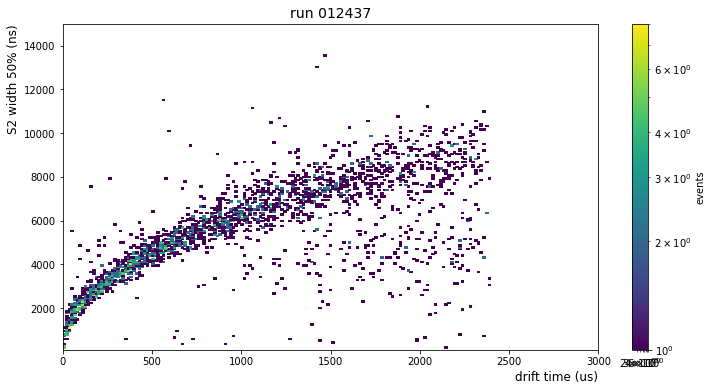

In [11]:
e3 = events[mask_doubleS1]
s2_width_vs_dt(e3['drift_time']/1e3,e3['s2_a_range_50p_area'],run_kr)

# Drift Velocity

Drift velocity = 0.633 +/- 0.003 mm/$\mu$s


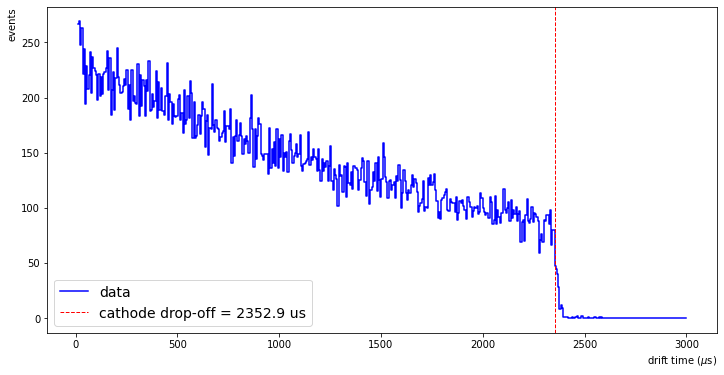

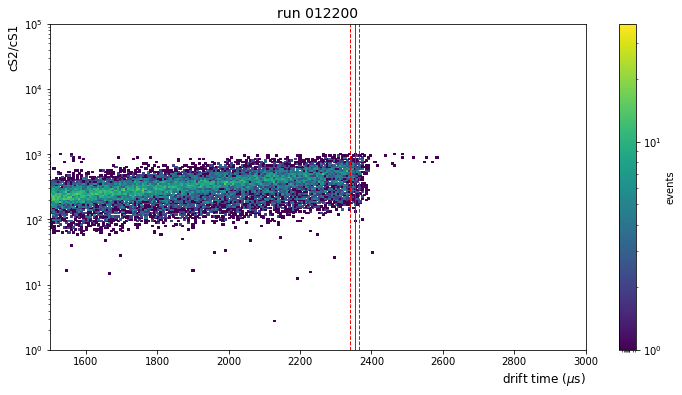

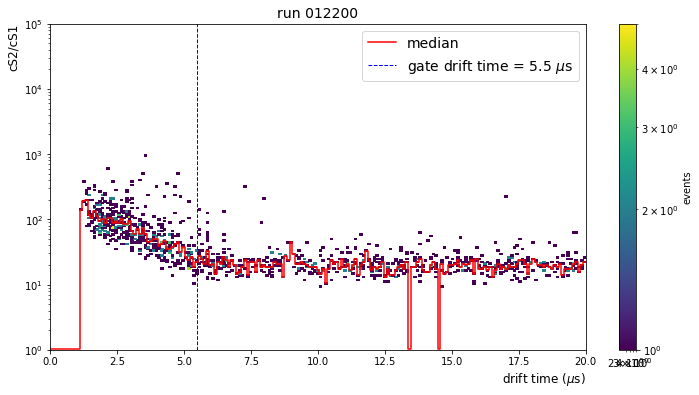

In [12]:
vd_kr, vd_kr_err = ddu.drift_velocity(e1,'012200', plot = True )

Diffusion constant = 43.03 +/- 0.13 cm$^2$/s 


(43.03234490387473, 0.13142375989324118)

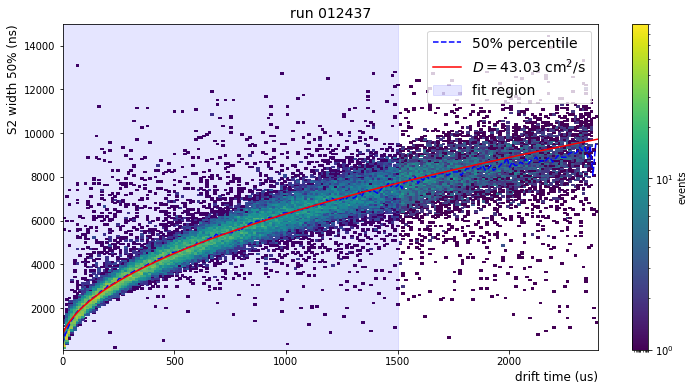

In [13]:
ddu.diffusion_constant(e2,run_kr,fit_range=(1,1500), vd = vd_kr, plot = True)

In [14]:
def diffusion_analysis(run_kr, area_cut=(5e3,1.1e4), fit_range=(1,1500), gate_pos = 5.5, plot=False):
    run = int(run_kr)
    events = st.get_df(run_kr,'event_info_double',progress_bar=False)
    if(plot): ddu.plot_area_width_aft(events, run_kr)
    mask_singleS1 = ddu.mask_KrSingleS1(events)
    if(plot): ddu.plot_area_width_aft(events[mask_singleS1], run_kr)
    e1 = events[mask_singleS1]
    mask_awt = ddu.mask_s2_area_width_aft(events,run_kr,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77),plot=plot)
    e2 = events[mask_singleS1 & mask_awt]
    vd, vd_err = ddu.drift_velocity(e1, run_kr, gate_pos = gate_pos, plot=plot)
    d, d_err = ddu.diffusion_constant(e2,run_kr,fit_range=(1,1500),vd = vd,plot=plot)
    if vd < 1: return run, vd, vd_err, d, d_err
    else: return run, 0, 0, 0, 0

In [43]:
d_ll5 = dsets[(dsets.number<=12245) & (dsets.livetime>np.timedelta64(30,'m'))] # 2021-01-26 19:11:31 - 2021-01-28 14:16:19
run_ll5 = np.array(d_ll5['name'])

In [44]:
runs, vd, vd_err, d, d_err = np.zeros(len(d_ll5)), np.zeros(len(d_ll5)), np.zeros(len(d_ll5)), np.zeros(len(d_ll5)), np.zeros(len(d_ll5))
for i, run in enumerate(run_ll5):
    runs[i], vd[i], vd_err[i], d[i], d_err[i] = diffusion_analysis(run, area_cut=(4e3,1.1e4), gate_pos = 5.5)

In [45]:
d_ll55 = dsets[(dsets.number>12245) & (dsets.number<=12443) & (dsets.livetime>np.timedelta64(30,'m'))]#2021-01-28 14:46-2021-02-01 2:29
run_ll55 = np.array(d_ll55['name'])

In [46]:
runs2, vd2, vd_err2, d2, d_err2 = np.zeros(len(d_ll55)), np.zeros(len(d_ll55)), np.zeros(len(d_ll55)), np.zeros(len(d_ll55)), np.zeros(len(d_ll55))
for i, run in enumerate(run_ll55):
    runs2[i], vd2[i], vd_err2[i], d2[i], d_err2[i] = diffusion_analysis(run, area_cut=(4e3,1.1e4), gate_pos = 5.5)

<ipython-input-62-3314262e0c09>:4: RuntimeWarning: invalid value encountered in true_divide
  d_err_corr = d_err+d*vd_err/vd


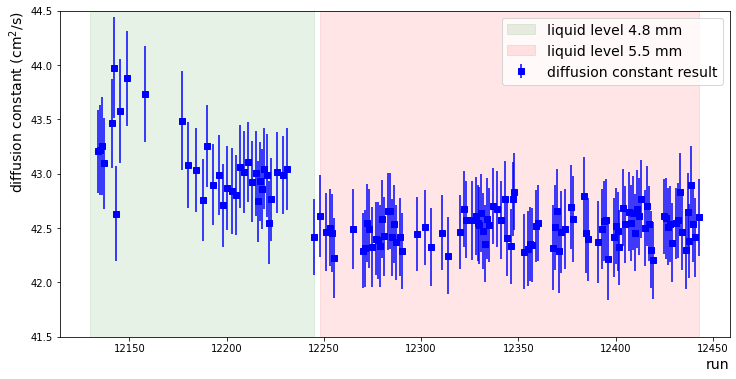

In [62]:
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("diffusion constant (cm$^2$/s)", ha='right', y=1,fontsize=14)
d_err_corr = d_err+d*vd_err/vd
d_err_corr2 = d_err2+d2*vd_err2/vd2
rr, dd, dd_err = np.concatenate((runs,runs2)), np.concatenate((d,d2)), np.concatenate((d_err_corr,d_err_corr2))
plt.errorbar(rr, dd, yerr = dd_err, fmt='s',c='b',label='diffusion constant result')
plt.axvspan(12130,12245, alpha=0.1, color='g', label='liquid level 4.8 mm')
plt.axvspan(12248,12443, alpha=0.1, color='r', label='liquid level 5.5 mm')
plt.ylim(41.5,44.5)
plt.legend(fontsize=14)

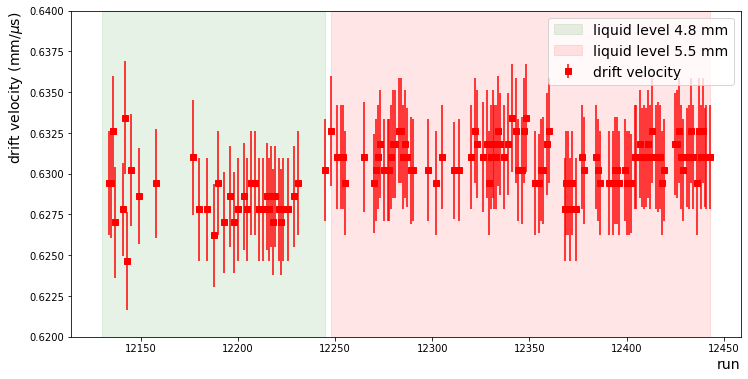

In [63]:
vdd, vdd_err = np.concatenate((vd,vd2)), np.concatenate((vd_err,vd_err2))
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("drift velocity (mm/$\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,vdd,yerr=vdd_err,fmt='s',color='r',label='drift velocity')
plt.axvspan(12130,12245, alpha=0.1, color='g', label='liquid level 4.8 mm')
plt.axvspan(12248,12443, alpha=0.1, color='r', label='liquid level 5.5 mm')
plt.ylim(0.62,0.64)
plt.legend(fontsize=14)

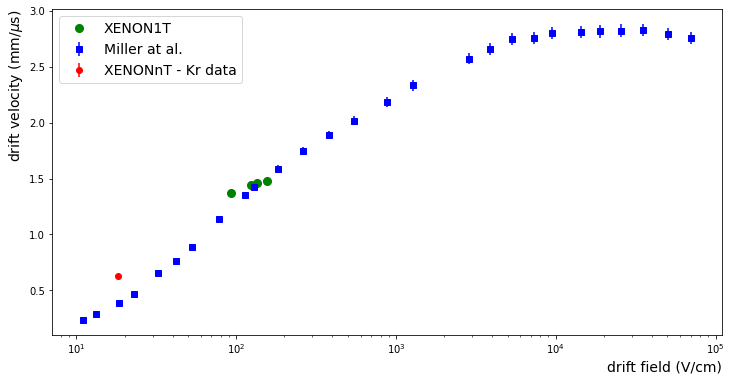

In [39]:
def pol5(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e * x + f

with open("DriftVelocity.txt") as f:
    data = f.read()
data = data.split('\n')
ind = [row.split('\t')[0] for row in data]
dt = [row.split('\t')[1] for row in data]
dv = [row.split('\t')[2] for row in data]
dt = np.array(dt, dtype=np.float32)
dv = np.array(dv, dtype=np.float32)
plt.figure(figsize=(12,6))
plt.errorbar(dt,dv,yerr=dv*0.02, c='b', fmt='s', label='Miller at al.')   
plt.xlabel('drift field (V/cm)',ha='right',x=1,fontsize=14)
plt.ylabel('drift velocity (mm/$\mu$s)',ha='right',y=1,fontsize=14)
plt.xscale('log')
popt, pcov = curve_fit(pol5, dt, dv)
#plt.plot(dt, pol5(dt, *popt), 'r--', label='fit')
plt.errorbar(18.3,vd_kr,yerr=vd_kr_err,fmt='o',color='r',label='XENONnT - Kr data')
field_1T = [155,134,124,92.8]
vd_1T = [1.482,1.456,1.440,1.371]
plt.plot(field_1T,vd_1T,marker='o',c='g',ms=8,lw=0,label='XENON1T')
plt.legend(fontsize=14)

In [60]:
d_ll5

,name,number,mode,end,start,tags,livetime,raw_records_available,peak_basics_available,event_info_available
1182,012245,12245,tpc_commissioning_kr83m,2021-01-28 14:16:19.514,2021-01-28 13:46:19.358,,0 days 00:30:00.156000,False,True,True
1196,012231,12231,tpc_commissioning_kr83m,2021-01-28 08:06:46.342,2021-01-28 07:36:46.081,,0 days 00:30:00.261000,False,True,True
1198,012229,12229,tpc_commissioning_kr83m,2021-01-28 07:06:17.583,2021-01-28 06:36:15.942,,0 days 00:30:01.641000,False,True,True
1201,012226,12226,tpc_commissioning_kr83m,2021-01-28 05:35:21.837,2021-01-28 05:05:21.605,,0 days 00:30:00.232000,False,True,True
1204,012223,12223,tpc_commissioning_kr83m,2021-01-28 04:04:35.194,2021-01-28 03:34:34.970,,0 days 00:30:00.224000,False,True,True
1205,012222,12222,tpc_commissioning_kr83m,2021-01-28 03:34:20.845,2021-01-28 03:04:20.655,,0 days 00:30:00.190000,False,True,True
1206,012221,12221,tpc_commissioning_kr83m,2021-01-28 03:04:06.479,2021-01-28 02:34:06.188,,0 days 00:30:00.291000,False,True,True
1208,012219,12219,tpc_commissioning_kr83m,2021-01-28 02:03:34.390,2021-01-28 01:33:34.155,,0 days 00:30:00.235000,False,True,True
1209,012218,12218,tpc_commissioning_kr83m,2021-01-28 01:33:16.910,2021-01-28 01:03:16.741,,0 days 00:30:00.169000,False,True,True
1210,012217,12217,tpc_commissioning_kr83m,2021-01-28 01:03:02.556,2021-01-28 00:33:02.022,,0 days 00:30:00.534000,False,True,True


In [61]:
d_ll55

,name,number,mode,end,start,tags,livetime,raw_records_available,peak_basics_available,event_info_available
984,012443,12443,tpc_commissioning_kr83m,2021-02-01 02:59:28.447,2021-02-01 02:29:27.804,,0 days 00:30:00.643000,False,True,True
986,012441,12441,tpc_commissioning_kr83m,2021-02-01 02:11:08.292,2021-02-01 01:41:06.993,,0 days 00:30:01.299000,False,True,True
987,012440,12440,tpc_commissioning_kr83m,2021-02-01 01:40:49.751,2021-02-01 01:10:47.417,,0 days 00:30:02.334000,False,True,True
988,012439,12439,tpc_commissioning_kr83m,2021-02-01 01:10:30.123,2021-02-01 00:40:27.634,,0 days 00:30:02.489000,False,True,True
989,012438,12438,tpc_commissioning_kr83m,2021-02-01 00:40:10.355,2021-02-01 00:10:08.841,,0 days 00:30:01.514000,False,True,True
...,...,...,...,...,...,...,...,...,...,...
1172,012255,12255,tpc_commissioning_kr83m,2021-01-28 17:48:22.292,2021-01-28 17:18:19.883,,0 days 00:30:02.409000,False,True,True
1173,012254,12254,tpc_commissioning_kr83m,2021-01-28 17:18:05.627,2021-01-28 16:48:03.581,,0 days 00:30:02.046000,False,True,True
1174,012253,12253,tpc_commissioning_kr83m,2021-01-28 16:47:46.372,2021-01-28 16:17:45.214,,0 days 00:30:01.158000,False,True,True
1176,012251,12251,tpc_commissioning_kr83m,2021-01-28 15:47:13.545,2021-01-28 15:17:10.957,,0 days 00:30:02.588000,False,True,True


# Cut S2 Width vs Drift Time

In [64]:
def s2width(dt, kind):
    "dt in us"
    if kind == "upper":
        # width = (800 ** 2 + (6000 ** 2 - 800 ** 2) / 800 * dt) ** 0.5 + 1100
        # width = (1000 ** 2 + (10500 ** 2 - 1000 ** 2) / 2400 * dt) ** 0.5 + 1100
        # from valerio's study
        width = _s2width(dt) + 1000
    elif kind == "lower":
        width = (800 ** 2 + (9200 ** 2 - 800 ** 2) / 2400 * dt) ** 0.5 - 1100
        # width = _s2width(dt) - 2000
    return width

def _s2width(t):
    """from valerio's study, https://xe1t-wiki.lngs.infn.it/doku.php?id=dandrea:krdata-s2event"""
    # assumed omega 0
    omega_0 = 1000  # us
    D = 51.89  # cm^2/s
    v = 0.63  # mm/us
    # output is ns
    coeff = 1e2
    width = np.sqrt(omega_0 ** 2 + 3.6395*D*t/v**2*coeff)
    return width

def AddS2WidthCut(df):
    mask_s2width = (df.s2_range_50p_area > s2width(df.drift_time/1e3, "lower")) \
                   & (df.s2_range_50p_area < s2width(df.drift_time/1e3, "upper"))
    # non-zero drif time
    mask_s2width &= df.drift_time > 0
    #df["CutS2Width"] = mask_s2width
    return mask_s2width

Loading event_info: |          | 0.00 % [00:00<?]

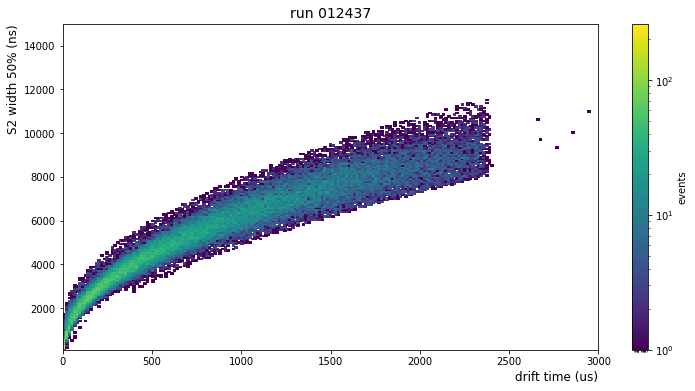

In [69]:
ev = st.get_df(run_kr,'event_info')
mask_s2width = AddS2WidthCut(ev)
ev2 = ev[mask_KrS1 & mask_s2width]
s2_width_vs_dt(ev2['drift_time']/1e3,ev2['s2_range_50p_area'],run_kr)

# Cut S1 Area Fraction Top vs Drift Time

In [135]:
def s1aft_dt_upper(dt):
    return dt*(0.65-0)/(0-3000) + 0.65

def s1aft_dt_lower(dt):
    return dt*(0.45-0.0)/(0-2000) + 0.45

def AddS1AFTCut(df):
    mask = (df.s1_area_fraction_top > s1aft_dt_lower(df.drift_time/1e3)) \
           & (df.s1_area_fraction_top < s1aft_dt_upper(df.drift_time/1e3))
    df["CutS1AFT"] = mask
    return df